<a href="https://colab.research.google.com/github/guptaShourya/DiabetesDetection/blob/main/DiabetesDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data visualisation
import seaborn as sns #data visualisation
from google.colab import drive #drive
drive.mount('/content/drive') #attach google drive
!pip install dataprep 
sns.set()

In [36]:
path = '/content/drive/My Drive/ML sem-5/Diabetes detection/data.csv'
# import data
data = pd.read_csv(path)

In [37]:
data.head(10) #display top 10 rows

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [38]:
# number of rows and columns in dataset
print("Data has {} rows, {} columns".format(data.shape[0], data.shape[1]))

Data has 768 rows, 9 columns


In [39]:
#number of nulls in dataset
print("Data has {} null values".format(data.isnull().any().sum()))

Data has 0 null values


In [40]:
# Statistical overview of data
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [41]:
# brief description of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


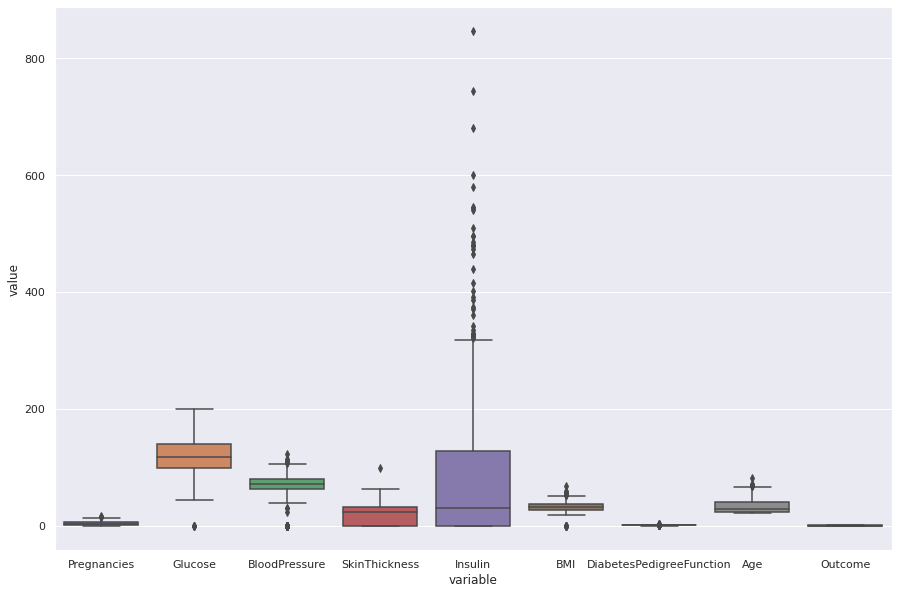

In [42]:
f, ax = plt.subplots(figsize = (15, 10)) # set size of the plot

sns.boxplot(x = "variable", y = "value", data = pd.melt(data), ax = ax) # use box plot to visualize outliers
plt.show() # display plot

In [43]:
def handleOutliers(data):
  Q1 = data.quantile(0.25) # calculate first quantile
  Q3 = data.quantile(0.75) # calculate third quantile
  IQR1 = Q3-Q1 # calculate inter quartile range

  data_c = data[~((data < (Q1-1.5*IQR1))|(data > (Q3+1.5*IQR1))).any(axis = 1)] # initialise data w/o outliers

  print('Data loss is {}%'.format(((len(data) - len(data_c))/len(data))*100)) # report data loss
  return data_c

In [45]:
data = handleOutliers(data)

Data loss is 16.796875%


In [57]:
def countMissing(data, col):
  return len(data[data[col] == 0]) # return count of missing values in column col

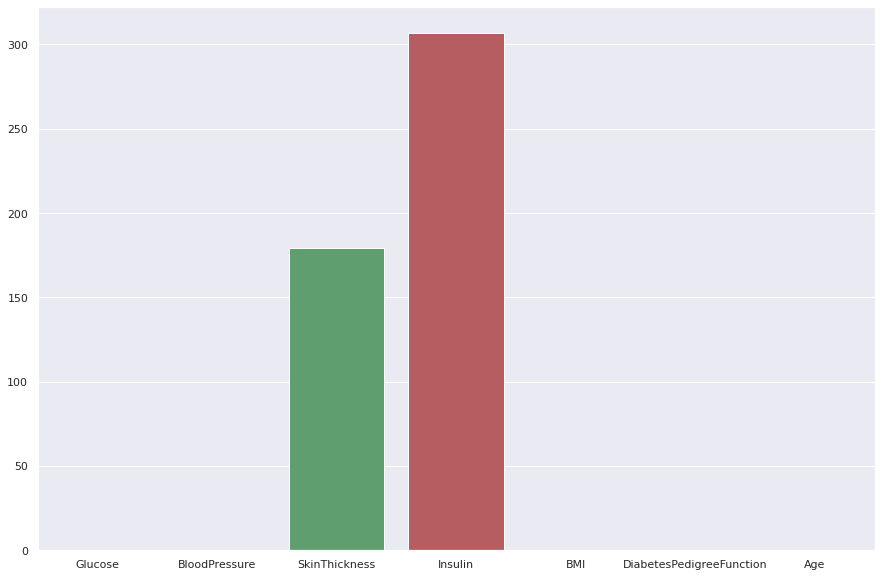

In [58]:
cols = list(data.columns)[1:-1] # columns check for missing values
missing_counts = [] # count of missing values

# for each column in columns
for col in cols:
  missing_counts.append(countMissing(data, col))

f, ax = plt.subplots(figsize = (15, 10)) # set size of the plot

sns.barplot(x = cols, y = missing_counts) # plot bar plot
plt.show() # display plot